In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from weight_diffusion.evaluation.util import load_logging_dict

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.5)

In [120]:
logging_dict = load_logging_dict("../logs.json")
PA_KEY = "prompt_alignment"
TARGETS_KEY = "targets"
TEST_ACC_KEY = "test_acc"
ROLL_TRAIN_ACC_KEY = "train_running_accuracy"
ROLL_TRAIN_LOSS_KEY = "train_running_loss"

In [107]:
def get_test_acc_from_prompt(prompt:str)->str:
    # TODO replace with regex
    return "Test Accuracy: " + prompt[-8:-2]

In [108]:
def plot_prompt_alignment(logging_dict):
    prompt_alignments = [
        (v[PA_KEY], v[TARGETS_KEY][TEST_ACC_KEY])
        for _, v in logging_dict.items()
    ]
    ax = sns.barplot(
        data=prompt_alignments,
    )
    ax.set_xticklabels([x[1] for x in prompt_alignments])
    ax.set_ylabel("Prompt Alignment (RMSE)")
    ax.set_xlabel("Prompted Test accuracy")
    ax.set_title("Prompt alignment across different prompts")

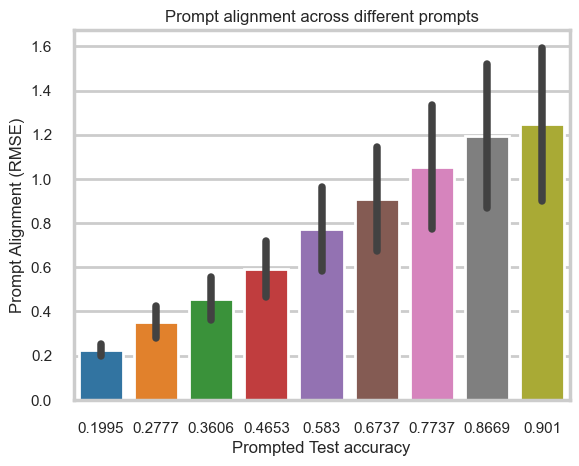

In [112]:
plot_prompt_alignment(logging_dict=logging_dict)
plt.savefig("/Users/alexanderlontke/Desktop/test.png")

In [145]:
def plot_desired_vs_observed(logging_dict, metric_key:str = "test_acc", epoch:int = 0):
    desired = [
        v[TARGETS_KEY][metric_key]
        for k,v in logging_dict.items()
    ]
    observed =[
        v[f"epoch_{epoch}"][metric_key]
        for _, v in logging_dict.items()
    ]
    ax = sns.lineplot(
        x=desired,
        y=observed,
    )
    ax.set_title(f"Desired vs. Observed {metric_key}")
    ax.set_xlabel(f"Desired {metric_key}")
    ax.set_ylabel(f"Observed {metric_key}")

In [ ]:
plot_desired_vs_observed(logging_dict=logging_dict, metric_key=TEST_ACC_KEY)
plt.savefig("/Users/alexanderlontke/Desktop/test_dvo.png", bbox_inches="tight")

In [ ]:
def plot_training_trajectory(logging_dict, metric:str):
    prompt_key = "Prompt"
    x = "Epoch"
    to_viz = {
        x: [],
        metric: [],
        prompt_key: [],
    }
    for k, v in logging_dict.items():
        data = v[metric]
        n = len(data)
        to_viz[x] += list(range(n))
        to_viz[metric] += data
        to_viz[prompt_key] += n * [get_test_acc_from_prompt(k)]
    to_viz = pd.DataFrame(to_viz)
    sns.lineplot(
        data=to_viz,
        x=x,
        y=metric,
        hue=prompt_key,
    )

In [ ]:
plot_training_trajectory(
    logging_dict=logging_dict,
    metric=ROLL_TRAIN_ACC_KEY,
)

In [ ]:
plot_training_trajectory(
    logging_dict=logging_dict,
    metric=ROLL_TRAIN_LOSS_KEY,
)

In [ ]:
def plot_deviations_per_prompt(logging_dict):
    fig, axs = plt.subplots(nrows=len(logging_dict.keys()), figsize=(10,20))
    axs = axs.flatten()
    metric_key = "Metric"
    deviation_key = "Deviation"
    for i, (k,v) in enumerate(logging_dict.items()):
        ax = axs[i]
        target = v["targets"]
        observed = v["epoch_0"]
        to_viz = {
            metric_key: [],
            deviation_key: []
        }
        for sk in target.keys():
            to_viz[metric_key] += [sk]
            to_viz[deviation_key] += [np.abs(target[sk] - observed[sk])]

        ax.set_title(f"Deviation between Desired and Observed Metric Value for Prompt: {get_test_acc_from_prompt(k)}")
        sns.barplot(
            data=pd.DataFrame(to_viz),
            x=metric_key,
            y=deviation_key,
            ax=ax
        )
        plt.tight_layout()

In [ ]:
plot_deviations_per_prompt(logging_dict=logging_dict)